# Pneumonia Detection on Chest X-ray Images Using Deep Learning

This project is carried out by *Eda AYDIN, Nesibe Betül DÖNER, Okan TOPAL, Berkay DİRİL* under the supervision of *Engin Deniz ALPMAN* in the **[Data Science for the Public Good program](https://www.kodluyoruz.org/bootcamp/data-science-for-the-public-good-istanbul-ankara/)**

The dataset of this project is obtained from the [Kaggle - Chest X-ray Images(Pneumonia](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) 

Note: The data sets to be used in the project comply with the health-ethical rules and are suitable for use as a license.


## What is Pneumonia?

<center><img src="https://www.drugs.com/health-guide/images/022dc126-fc5d-4e54-9a78-75f2c9ea4bb6.jpg"/></center>

Pneumonia is an inflammatory condition of the lung that affects the small air sacs known as alveoli. It typically includes symptoms such as a dry cough, chest pain, fever, and difficulty breathing. The severity of the condition varies from person to person. 

Pneumonia is usually caused by infection with viruses or bacteria, and less commonly by conditions such as other microorganisms, certain medications, or autoimmune diseases.

Risk factors include cystic fibrosis, chronic obstructive pulmonary disease (COPD), asthma, diabetes, heart failure, smoking history, poor ability to cough after stroke, and a weak immune system. 

Diagnosis is usually based on symptoms and physical examination. A chest X-ray, blood tests, and sputum culture can help confirm the diagnosis. 



## What is CNN (Convolutional Neural Network) ?

CNN stands for Convolutional Neural Network which is a specializaed neural network for processing data that has an input shape like a 2D matrix like images. CNN's are typically used for image detection and classification.

## A. BUSINESS UNDERSTANDING


### Context
![Example of Chest X-rays in patients](https://i.imgur.com/jZqpV51.png)

The normal chest X-ray(left panel) depicts clear lungs without any areas of abnormal opacification in the image.
Bacterical pneumonia (middle panel) typically exhibits a focal lobar consolidation, in this case in the right upper lobe (white arrows), whereas viral pneumonia(right panel) manifets with a more diffuse "interstitial" pattern in both lungs.

### Content

The dataset is organized into 3 folders (train, test, val) and contains subfolders of each image category (Pneumonia / Normal). There are 5,863 X-Ray images (JPEG) and 2 categories(Pneumonia/Normal)

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.





## B. DATA UNDERSTANDING

### Installation the Libraries

In [ ]:
!pip install opendatasets --upgrade --quiet

### Import Libraries


In [ ]:
# Import libraries
import os
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
import opendatasets as od

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import random
from pathlib import Path #to be able to use functions using path


# Data science tools
import pandas as pd # data processing
import numpy as np # linear algebra

# Tensorflow for GPU
import tensorflow as tf
from tensorflow.compat.v1 import Session, ConfigProto, set_random_seed
from tensorflow.python.client import device_lib

# Keras library for Modeling
import keras
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Conv2D, MaxPool2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.callbacks import ReduceLROnPlateau
from keras.applications.inception_v3 import InceptionV3
from keras.constraints import maxnorm
from keras import backend as K

# OpenCV
import cv2

# Resize images
from skimage.io import imread
from skimage.transform import resize

# Scikit-learn library
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Visualizations
from PIL import Image
import imgaug as aug
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
import matplotlib.image as mimg # images
%matplotlib inline
import seaborn as sns
import plotly.express as px

### Downloading the data

In [ ]:
od.download("https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia")

Skipping, found downloaded files in "./chest-xray-pneumonia" (use force=True to force download)


In [ ]:
# Directories where you'll store the data
base_dir = Path("chest-xray-pneumonia/chest_xray/chest_xray/")


In [ ]:
# Directories for the training, validation, and test splits
train_dir = base_dir /"train/" 
val_dir = base_dir /"val/"
test_dir = base_dir /"test/"

### Changing the environment CPU to GPU (Check the GPU Environment)

In [ ]:
tf.__version__

'2.7.0'

In [ ]:
%tensorflow_version 2.7
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.7`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.
Found GPU at: /device:GPU:0


### Data Loading

#### Data Loading for Train Dataset

In [ ]:
os.listdir(train_dir)

['NORMAL', 'PNEUMONIA', '.DS_Store']

In [ ]:
train_normal_dir = train_dir /"NORMAL" #to set the path to the normals in train set
train_pneumonia_dir = train_dir /"PNEUMONIA" #to set the path to the pneumonias in train set

#### Data Loading for Validation Dataset

In [ ]:
os.listdir(val_dir)

['NORMAL', 'PNEUMONIA', '.DS_Store']

In [ ]:
valid_normal_dir = val_dir /"NORMAL" #to set the path to the normals in validation set
valid_pneumonia_dir = val_dir /"PNEUMONIA" #to set the path to the pneumonias in validation set

#### Data Loading for Test Dataset

In [ ]:
os.listdir(test_dir)

['NORMAL', 'PNEUMONIA', '.DS_Store']

In [ ]:
test_normal_dir = test_dir /"NORMAL" #to set the path to the normals in test set
test_pneumonia_dir = test_dir /"PNEUMONIA" #to set the path to the pneumonias in test set

### Labeling

#### Setting the dataset for training

In [ ]:
train_normal= train_normal_dir.glob("*.jpeg") #to take the normal images from train set 
train_pneumonia=train_pneumonia_dir.glob("*.jpeg") #to take the pneumonia images from the train set
train_set=[]#to add all the train data into one list, we created a blank list

In [ ]:
for img in train_normal: #to add every image of normals in trainset to the list
  train_set.append((img, 0)) #we add 0 with normal images as label
for img in train_pneumonia:#to add every image of pneumonias in trainset to the list
  train_set.append((img, 1)) #we add 1 with pneumonia images as label

In [ ]:
print(train_set[:15]) #to check what our list look like

[(PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0648-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0663-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/IM-0332-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/IM-0592-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/IM-0533-0001-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/IM-0128-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/IM-0502-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-1089-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0496-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0689-0001.jpeg'), 0), (PosixPath('chest-xray-p

In [ ]:
train_set=pd.DataFrame(train_set, columns=["image", "label"], index=None)#to create a dataframe from the list, so that we can use dataframe features

In [ ]:
train_set.head() #to see the first 5 rows of our dataframe, only normals are shown since we added them first.

,image,label
0,chest-xray-pneumonia/chest_xray/chest_xray/tra...,0
1,chest-xray-pneumonia/chest_xray/chest_xray/tra...,0
2,chest-xray-pneumonia/chest_xray/chest_xray/tra...,0
3,chest-xray-pneumonia/chest_xray/chest_xray/tra...,0
4,chest-xray-pneumonia/chest_xray/chest_xray/tra...,0


In [ ]:
train_set=train_set.sample(frac=1) #to shuffle all the rows in dataframe so that we can see normal and pneumonia in random
train_set=train_set.reset_index(drop=True) #to set the indexes as if first time
train_set.head()

,image,label
0,chest-xray-pneumonia/chest_xray/chest_xray/tra...,1
1,chest-xray-pneumonia/chest_xray/chest_xray/tra...,1
2,chest-xray-pneumonia/chest_xray/chest_xray/tra...,1
3,chest-xray-pneumonia/chest_xray/chest_xray/tra...,1
4,chest-xray-pneumonia/chest_xray/chest_xray/tra...,1


#### Setting the dataset for valdiation

In [ ]:
valid_normal= valid_normal_dir.glob("*.jpeg") #to take the normal images from validation set 
valid_pneumonia=valid_pneumonia_dir.glob("*.jpeg") #to take the pneumonia images from the validation set
valid_set=[] #to add all the validation data into one list, we created a blank list

In [ ]:
for img in valid_normal: #to add every image of normals in validationset to the list
  valid_set.append((img, 0)) #we add 0 with normal images as label
for img in valid_pneumonia:#to add every image of pneumonias in validationset to the list
  valid_set.append((img, 1)) #we add 1 with pneumonia images as label


In [ ]:
print(valid_set[:15]) #to check what our list look like

[(PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1440-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1431-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1436-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1430-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1427-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1442-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1437-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1438-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg'), 1), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg'),

In [ ]:
valid_set=pd.DataFrame(valid_set, columns=["image", "label"], index=None)#to create a dataframe from the list, so that we can use dataframe features
valid_set.head() #to see the first 5 rows of our dataframe, only normals are shown since we added them first.

,image,label
0,chest-xray-pneumonia/chest_xray/chest_xray/val...,0
1,chest-xray-pneumonia/chest_xray/chest_xray/val...,0
2,chest-xray-pneumonia/chest_xray/chest_xray/val...,0
3,chest-xray-pneumonia/chest_xray/chest_xray/val...,0
4,chest-xray-pneumonia/chest_xray/chest_xray/val...,0


In [ ]:
valid_set=valid_set.sample(frac=1) #to shuffle all the rows in dataframe so that we can see normal and pneumonia in random
valid_set=valid_set.reset_index(drop=True) #to set the indexes as if first time
valid_set.head()

,image,label
0,chest-xray-pneumonia/chest_xray/chest_xray/val...,0
1,chest-xray-pneumonia/chest_xray/chest_xray/val...,1
2,chest-xray-pneumonia/chest_xray/chest_xray/val...,0
3,chest-xray-pneumonia/chest_xray/chest_xray/val...,1
4,chest-xray-pneumonia/chest_xray/chest_xray/val...,0


#### Setting the dataset for test

In [ ]:
test_normal= test_normal_dir.glob("*.jpeg") #to take the normal images from test set 
test_pneumonia=test_pneumonia_dir.glob("*.jpeg") #to take the pneumonia images from the test set
test_set=[]#to add all the test data into one list, we created a blank list

In [ ]:
for img in test_normal: #to add every image of normals in test set to the list
  test_set.append((img, 0)) #we add 0 with normal images as label
for img in test_pneumonia:#to add every image of pneumonias in test set to the list
  test_set.append((img, 1)) #we add 1 with pneumonia images as label


In [ ]:
print(test_set[:15]) #to check what our list look like

[(PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/NORMAL2-IM-0288-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/NORMAL2-IM-0278-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/NORMAL2-IM-0052-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/IM-0023-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/IM-0028-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/IM-0109-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/NORMAL2-IM-0139-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/NORMAL2-IM-0352-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/NORMAL2-IM-0081-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/IM-0070-0001.jpeg'), 0), (PosixPath('chest-xray-pneumoni

In [ ]:
test_set=pd.DataFrame(test_set, columns=["image", "label"], index=None)#to create a dataframe from the list, so that we can use dataframe features
test_set.head() #to see the first 5 rows of our dataframe, only normals are shown since we added them first.

,image,label
0,chest-xray-pneumonia/chest_xray/chest_xray/tes...,0
1,chest-xray-pneumonia/chest_xray/chest_xray/tes...,0
2,chest-xray-pneumonia/chest_xray/chest_xray/tes...,0
3,chest-xray-pneumonia/chest_xray/chest_xray/tes...,0
4,chest-xray-pneumonia/chest_xray/chest_xray/tes...,0


In [ ]:
test_set=test_set.sample(frac=1) #to shuffle all the rows in dataframe so that we can see normal and pneumonia in random
test_set=test_set.reset_index(drop=True) #to set the indexes as if first time
test_set.head()

,image,label
0,chest-xray-pneumonia/chest_xray/chest_xray/tes...,0
1,chest-xray-pneumonia/chest_xray/chest_xray/tes...,1
2,chest-xray-pneumonia/chest_xray/chest_xray/tes...,1
3,chest-xray-pneumonia/chest_xray/chest_xray/tes...,0
4,chest-xray-pneumonia/chest_xray/chest_xray/tes...,0


### Data Visualization

In [ ]:
# Normal Image
train_normal_count= train_set.loc[train_set["label"]==0]["image"].count()
print("Total number of normal images:", train_normal_count)

Total number of normal images: 1341


In [ ]:
# Pneumonia Image
train_pneumonia_count= train_set.loc[train_set["label"]==1]["image"].count()
print("Total number of pneumonia images:", train_pneumonia_count)

Total number of pneumonia images: 3875


#### Normal / Pneumonia Image Visualization for Train Dataset

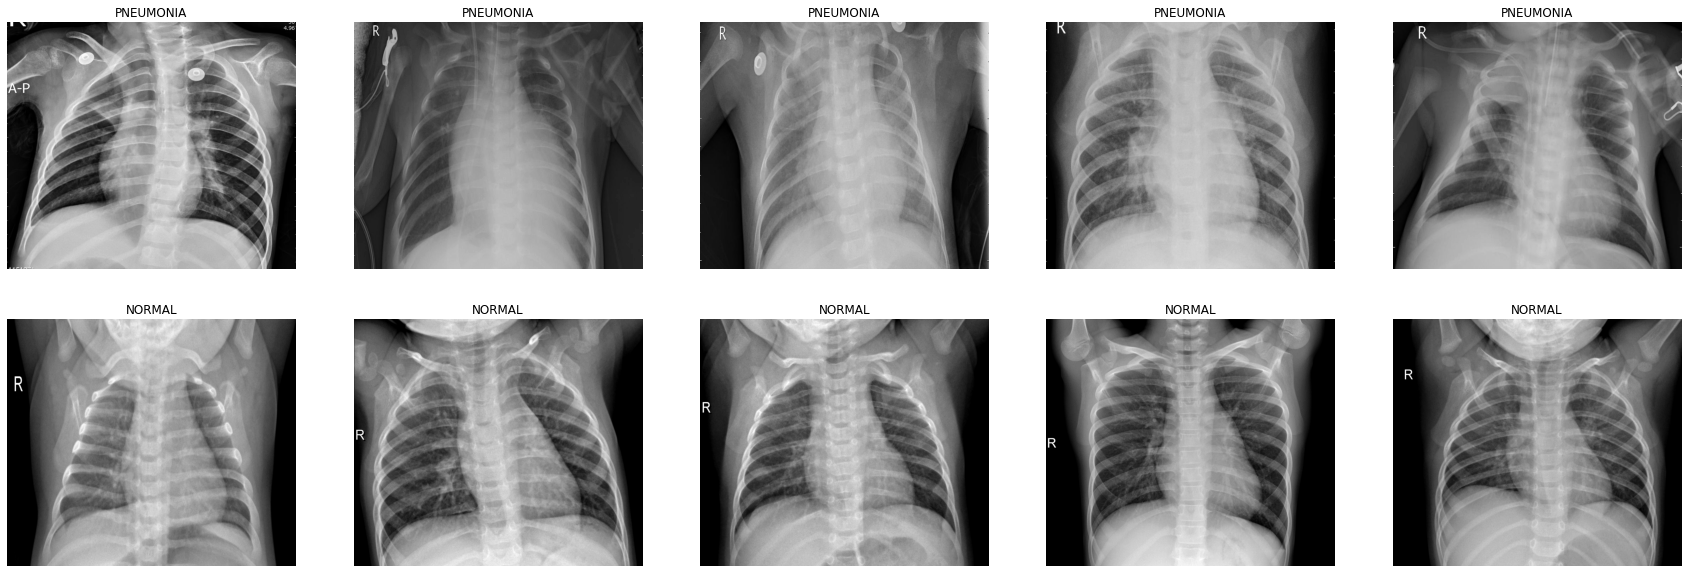

In [ ]:
# Get few samples for both the classes
pneumonia_samples = (train_set[train_set["label"] == 1]["image"].iloc[:5]).tolist()
normal_samples = (train_set[train_set["label"] == 0]["image"].iloc[:5]).tolist()

# Concate the data in a single list and del the above two list
samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# Plot the data
f, ax = plt.subplots(2,5, figsize = (30,10))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i % 5].imshow(img, cmap='gray')
    if i < 5:
        ax[i//5, i % 5].set_title("PNEUMONIA")
    else:
        ax[i//5, i % 5].set_title("NORMAL")
    ax[i//5, i % 5].axis('off')
    ax[i//5, i % 5].set_aspect('auto')
plt.show()

#### Plotting the Data Distribution

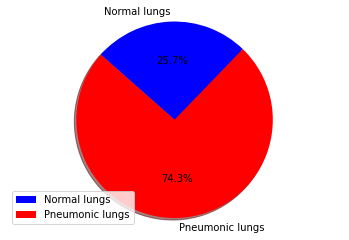

In [ ]:
fig1,ax1= plt.subplots()
sizes=[train_normal_count, train_pneumonia_count]
ax1.pie(sizes, startangle=46 ,labels=["Normal lungs","Pneumonic lungs"], autopct="%1.1f%%", shadow=True, colors=["b","r"])
ax1.axis("equal")
plt.legend()
plt.show()

Text(0.5, 1.0, 'Case Distribution')

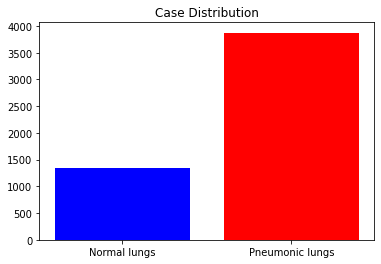

In [ ]:
fig2, ax2=plt.subplots()
ax2.bar(height=sizes, x=["Normal lungs", "Pneumonic lungs"], color=["blue", "red"])
plt.title("Case Distribution")

According to this result, we have imbalanced image dataset. We will increase the "Normal" image dataset using Data Augmentation to correct this imbalance.

### Data Preparation

#### Data Distribution

In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150


def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                # Reshaping images to preferred size
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)


In [ ]:
train = get_training_data(train_dir)
test = get_training_data(test_dir)
val = get_training_data(val_dir)

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



In [ ]:
# initialize multiple lists
X_train, X_val, X_test = ([], ) * 3
y_train, y_val, y_test = ([], ) * 3

for feature, label in train:
    X_train.append(feature)
    y_train.append(label)

for feature, label in val:
    X_val.append(feature)
    y_val.append(label)

for feature, label in test:
    X_test.append(feature)
    y_test.append(label)

We perform a grayscale normalization to reduce the effect of illumination's differences. Moreover the CNN converges faster on [0..1] data than on [0..255].

#### Data Normalization

In [ ]:
X_train = np.array(X_train) /255
X_val = np.array(X_val) / 255
X_test = np.array(X_test) / 255

#### Reshaping the data for deep learning model

In [ ]:
X_train = X_train.reshape (-1, img_size, img_size, 1)
y_train = np.array(y_train)

X_val = X_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

X_test = X_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

## C. DATA AUGMENTATION

To avoid the overfitting problem, we need to artificially expand our dataset. We can further enlarge your existing dataset. The idea is to manipulate the training data with small transformations to reproduce the variations. Approaches that modify the training data to change the sequence representation while keeping the label the same are known as data augmentation techniques. Some popular magnifications people use are grayscales, horizontal flips, vertical flips, random crops, dithering, offsets, rotations, and much more. By applying just a few of these transformations to our training data, we can easily double or triple the number of training samples and create a very robust model. 

### Getting Train Generator

In [ ]:
# normalize and augment images
image_generator = ImageDataGenerator(
  featurewise_center = False, # set input mean to 0 over the dataset
  samplewise_center = False, # set each sample mean to 0
  featurewise_std_normalization = False, #divide inputs by std of the dataset
  samplewise_std_normalization = False, # divide each input by its std
  zca_whitening=False,  # apply ZCA whitening
  rotation_range =30, #randomly rotate images in the range
  zoom_range = 0.2, #randomly zoom image
  width_shift_range = 0.1, #randomly shift images horizontally
  height_shift_range = 0.1, #randomly shift images vertically
  horizontal_flip = True, #randomly flip images
  vertical_flip = False) #randomly flip images
  
image_generator.fit(X_train)

For the data augmentation, we choosed to:

1. Randomly rotate some training images by 30 degrees
2. Randomly Zoom by 20% saome training images
3. Randomly shift imags horizontally by 10% of the width
4. Randomly shift images vertically by 10% of the height
5. Randomly flip images horizontally



## D. DATA MODELLING

### D.1 Building CNN Model

In [ ]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       2

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.3, min_lr=0.000001)

In [ ]:
history = model.fit(image_generator.flow(X_train, y_train, batch_size=32), epochs=15, validation_data=image_generator.flow(X_val, y_val), callbacks=[learning_rate_reduction])

Epoch 1/15
183/183 [==============================] - 34s 163ms/step - loss: 0.6204 - accuracy: 0.8367 - val_loss: 10.4507 - val_accuracy: 0.7297 - lr: 0.0010
Epoch 2/15
183/183 [==============================] - 29s 158ms/step - loss: 0.2825 - accuracy: 0.8948 - val_loss: 15.3261 - val_accuracy: 0.7297 - lr: 0.0010
Epoch 3/15
183/183 [==============================] - 29s 159ms/step - loss: 0.2469 - accuracy: 0.9100 - val_loss: 0.4844 - val_accuracy: 0.7696 - lr: 0.0010
Epoch 4/15
183/183 [==============================] - 29s 161ms/step - loss: 0.2253 - accuracy: 0.9153 - val_loss: 11.7507 - val_accuracy: 0.7297 - lr: 0.0010
Epoch 5/15
183/183 [==============================] - ETA: 0s - loss: 0.2124 - accuracy: 0.9278
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
183/183 [==============================] - 30s 162ms/step - loss: 0.2124 - accuracy: 0.9278 - val_loss: 2.7941 - val_accuracy: 0.4078 - lr: 0.0010
Epoch 6/15
183/183 [======================

In [ ]:
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

183/183 [==============================] - 4s 22ms/step - loss: 0.1278 - accuracy: 0.9525
Loss of the model is -  0.12777167558670044
183/183 [==============================] - 4s 22ms/step - loss: 0.1278 - accuracy: 0.9525
Accuracy of the model is -  95.25273442268372 %


## E.EVALUATION

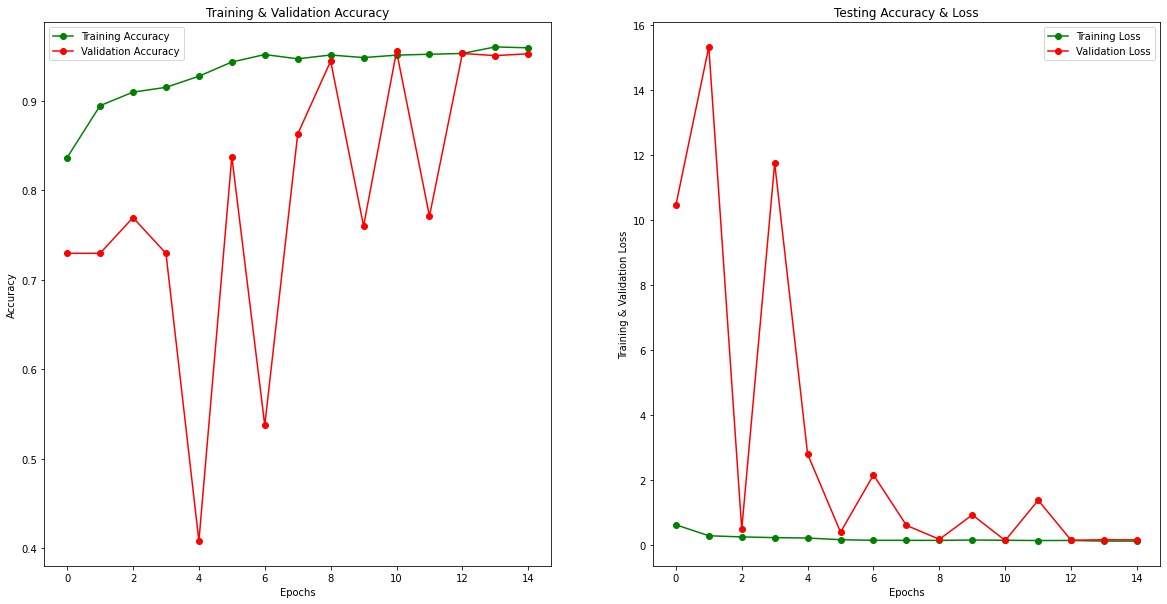

In [ ]:
epochs = [i for i in range(15)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [ ]:
predictions = (model.predict(X_test) > 0.5).astype("int32")
predictions = predictions.reshape(1, -1)[0]
predictions[:15]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [ ]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.99      0.95      0.97      4273
   Normal (Class 1)       0.87      0.97      0.92      1583

           accuracy                           0.95      5856
          macro avg       0.93      0.96      0.94      5856
       weighted avg       0.96      0.95      0.95      5856



In [ ]:
cm = confusion_matrix(y_test, predictions)
cm


array([[4047,  226],
       [  52, 1531]])

In [ ]:
cm = pd.DataFrame(cm, index=['0', '1'], columns=['0', '1'])


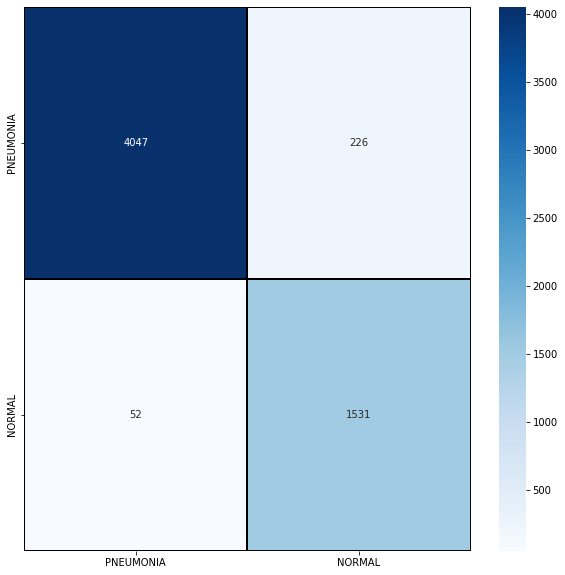

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [ ]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]


## F. PROOF

### F.1 Some of the Correctly Predicted Classes

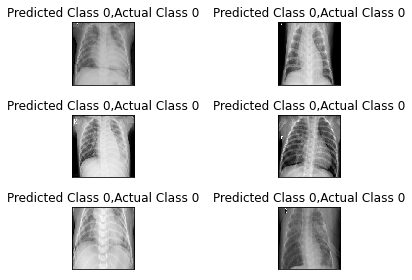

In [ ]:
i = 0
for c in correct[:6]:
    plt.subplot(3, 2, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[c].reshape(150, 150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(
        predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1


### F.2 Some of the Incorrectly Predicted Class

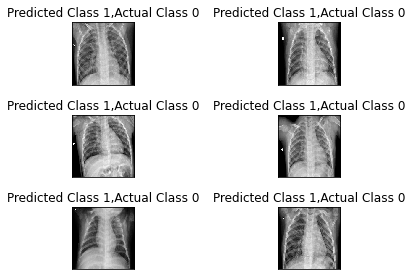

In [ ]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3, 2, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[c].reshape(150, 150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1


## G. RESOURCES

**Notebook Resources**

  * https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia
  * https://www.kaggle.com/aakashnain/beating-everything-with-depthwise-convolution
  * https://www.kaggle.com/amyjang/tensorflow-pneumonia-classification-on-x-rays
  * https://www.kaggle.com/madz2000/pneumonia-detection-using-cnn-92-6-accuracy
  * https://www.kaggle.com/sanwal092/intro-to-cnn-using-keras-to-predict-pneumonia
  * https://www.kaggle.com/homayoonkhadivi/medical-diagnosis-with-cnn-transfer-learning
  * https://www.kaggle.com/arbazkhan971/pneumonia-detection-using-cnn-96-accuracy
  * https://jovian.ai/edaaydinea/applying-cnn-on-chest-xray-images

**Website Resources**

* ***Tensorflow - Keras Documentations***
    * https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
    * https://keras.io/api/layers/convolution_layers/

* ***Others***
    * https://towardsdatascience.com/deep-learning-in-healthcare-x-ray-imaging-part-5-data-augmentation-and-image-normalization-1ead1c02cfe3

* **Book Resouces**
    * Hands-on Machine Learning with Scikit-Learn, Keras & Tensorflow
    * Deep Learning with Python
    * Tensorflow for Deep Learning
    * Programming Computer Vision with Python